In [1]:
from MALDINet import _MALDINet
from utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='4'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

## Data_1 共3个子任务

### 1. 人类皮肤测试 健康：皮肤痣：脱水 = 30：24：12

In [4]:
dfx = LoadMSData(root_path = root_path, data_path = 'data1/human/peaks_0.2.csv', t = False)
Y = np.zeros((66,3))                                             #将标签以独热编码存起来66
for i in range (0,30):                                           #健康 30例
    Y[i,0] = 1                                                     
for i in range (30,54):                                          #皮肤痣 24例
    Y[i,1] = 1                                                    
for i in range (54,66):                                          #脱水 12例
    Y[i,2] = 1 
y = Y.astype(int)
Y = np.zeros(66)                                                 #用于分层的标签
for i in range (0,30):                                           #健康 30例
    Y[i] = 0                                                    
for i in range (30,54):                                          #皮肤痣 24例
    Y[i] = 1
for i in range (54,66):                                          #脱水 12例
    Y[i] = 2
Y = Y.astype(int)

In [8]:
mp = AggMap(dfx, metric = 'euclidean')                          #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, mpsave_path = save_path, data_num = 'data1', file_type = 'aggmap', file_name = 'aggmap_human_0.2.mp')

2023-12-21 16:52:14,634 - INFO - [bidd-aggmap] - Calculating distance ...
2023-12-21 16:52:14,643 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 73/73 [00:00<00:00, 484.70it/s]


2023-12-21 16:52:15,635 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2023-12-21 16:52:20,355 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2023-12-21 16:52:20,375 - INFO - [bidd-aggmap] - Finished


In [9]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
SaveMpOrX(data = mp, mpsave_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_human_0.2.dat')

100%|##########| 66/66 [00:04<00:00, 15.90it/s]


In [5]:
mp = load('/mnt/lzyt/SmallSamples/data1/aggmap/aggmap_human_0.2.mp')
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
X

100%|##########| 66/66 [00:04<00:00, 15.20it/s]


array([[[[0.        , 0.        , 0.43901421, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.51576595, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.00458566,
          0.        , 0.        ],
         [0.        , 0.        , 0.39305769, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.35752812, ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.13026702, ..., 0.        ,
          0.        , 0. 

In [17]:
#原代码 复现
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = AggMapNet.MultiClassEstimator(epochs=200,gpuid=4,conv1_kernel_size=3)         #显存不足记得更改gpu
    clf.fit(train_X, train_Y)                                       #模型训练
    
    #AggMapNet Test Metrics
    acc = accuracy_score(test_y,clf.predict(test_X))
    rec = recall_score(test_y, clf.predict(test_X),average="micro")
    f1 = f1_score(test_y, clf.predict(test_X),average="micro")
    pr = precision_score(test_y, clf.predict(test_X),average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc = Sum_acc + acc
Sum_acc / 5

MultiClassEstimator(batch_norm=False, batch_size=128, conv1_kernel_size=3,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=200, gpuid='4', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0
MultiClassEstimator(batch_norm=False, batch_size=128, conv1_kernel_size=3,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=200, gpuid='4', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
Acc 

0.9846153846153847

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


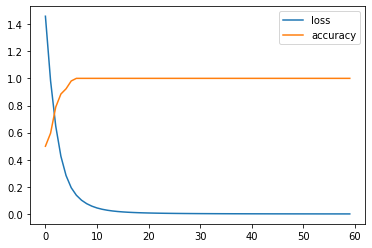

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


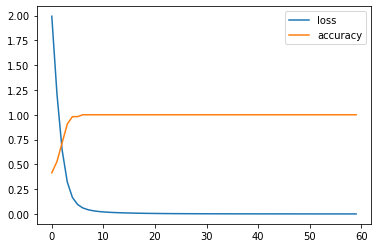

Acc =  0.9230769230769231
f1_score =  0.9230769230769231
average_precision =  0.9230769230769231
recall_score =  0.9230769230769231


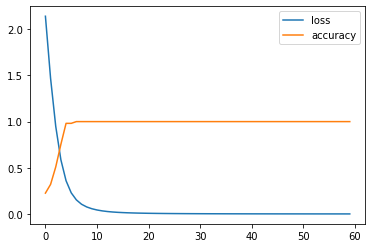

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


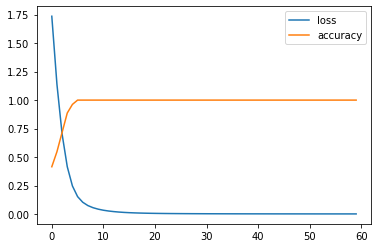

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


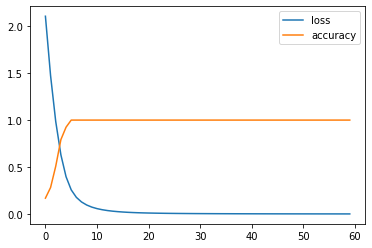

0.9846153846153847

In [28]:
#Cross-validation and test 单核最佳结果
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='3',dense_layers=[128], dropout = 0)
    opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    history = clf.fit(train_X, train_Y, batch_size=128, epochs=60, verbose=0)

    probs = clf.predict(test_X)
    y_pred = np.argmax(probs, axis=1)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc = Sum_acc + acc
    #plot train curve
    PlotCurve(history)
Sum_acc / 5

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


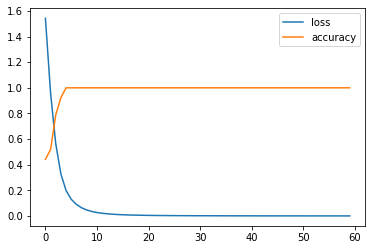

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


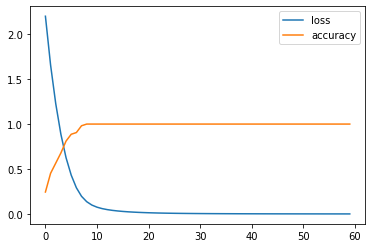

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


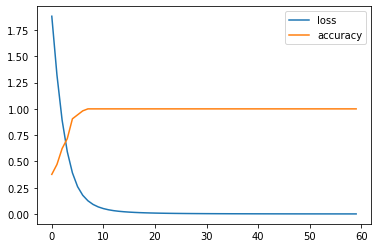

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


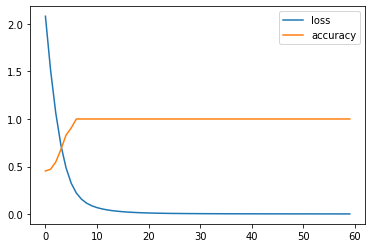

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


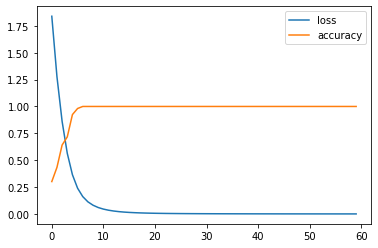

1.0

In [35]:
#Cross-validation and test 双核最佳结果
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='DK',dense_layers=[128], dropout = 0)
    opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    history = clf.fit(train_X, train_Y, batch_size=128, epochs=60, verbose=0)

    probs = clf.predict(test_X)
    y_pred = np.argmax(probs, axis=1)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc = Sum_acc + acc
    #plot train curve
    PlotCurve(history)
Sum_acc / 5

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


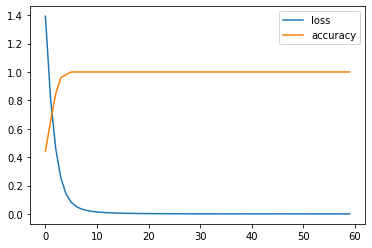

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


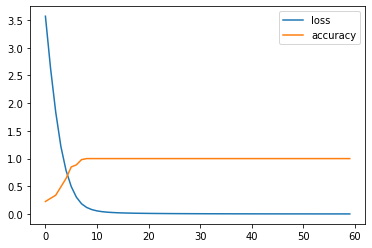

Acc =  0.9230769230769231
f1_score =  0.9230769230769231
average_precision =  0.9230769230769231
recall_score =  0.9230769230769231


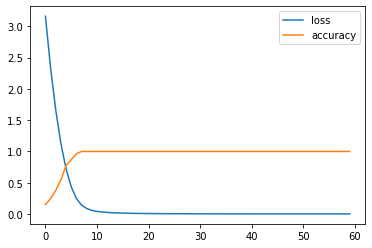

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


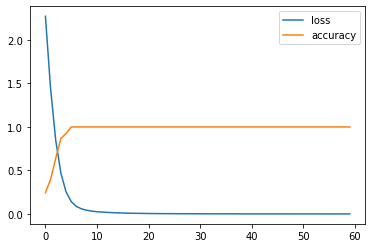

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


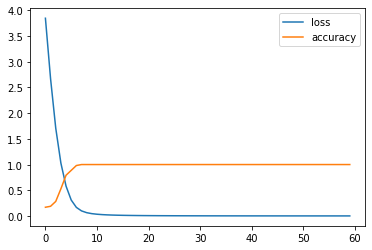

0.9846153846153847

In [37]:
#Cross-validation and test 三核最佳结果
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='MK',dense_layers=[128], dropout = 0)
    opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    history = clf.fit(train_X, train_Y, batch_size=64, epochs=60, verbose=0)

    probs = clf.predict(test_X)
    y_pred = np.argmax(probs, axis=1)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc = Sum_acc + acc
    #plot train curve
    PlotCurve(history)
Sum_acc / 5

### 2. 小鼠皮肤测试 健康：黑色素瘤：早期肿瘤：中期肿瘤：晚期肿瘤 = 18：6：9：6：12

In [35]:
dfx = LoadMSData(root_path = root_path, data_path = 'data1/mouse_skin/peaks_0.2.csv', t = False)
Y = np.zeros((51,5))                                             #将标签以独热编码存起来51
for i in range (0,18):                                           #健康 18例
    Y[i,0] = 1                                                     
for i in range (18,24):                                          #黑色素瘤 6例
    Y[i,1] = 1                                                    
for i in range (24,33):                                          #早期 9例
    Y[i,2] = 1 
for i in range (33,39):                                          #中期 6例
    Y[i,3] = 1                                                    
for i in range (39,51):                                          #晚期 12例
    Y[i,4] = 1 
y = Y.astype(int)
Y = np.zeros(51)                                                 #用于分层的标签
for i in range (0,18):                                           #健康 18例
    Y[i] = 0                                                     
for i in range (18,24):                                          #黑色素瘤 6例
    Y[i] = 1                                                    
for i in range (24,33):                                          #早期 9例
    Y[i] = 2 
for i in range (33,39):                                          #中期 6例
    Y[i] = 3                                                    
for i in range (39,51):                                          #晚期 12例
    Y[i] = 4 
Y = Y.astype(int)

In [36]:
mp = AggMap(dfx, metric = 'euclidean')                          #使用欧式距离
mp.fit(cluster_channels=5, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data1', file_type = 'aggmap', file_name = 'aggmap_mouse_skin_0.2.mp')

2023-12-21 19:10:12,405 - INFO - [bidd-aggmap] - Calculating distance ...
2023-12-21 19:10:12,411 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 104/104 [00:00<00:00, 716.88it/s]


2023-12-21 19:10:13,873 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2023-12-21 19:10:14,165 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2023-12-21 19:10:14,182 - INFO - [bidd-aggmap] - Finished


In [28]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_mouse_skin_0.2.dat')

100%|##########| 51/51 [00:00<00:00, 269.04it/s]


In [29]:
#原代码 复现
#Cross-validation and test
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = AggMapNet.MultiClassEstimator(epochs=200,gpuid=4,conv1_kernel_size=3)         #显存不足记得更改gpu
    clf.fit(train_X, train_Y)                                       #模型训练
    
    #AggMapNet Test Metrics
    acc = accuracy_score(test_y,clf.predict(test_X))
    rec = recall_score(test_y, clf.predict(test_X),average="micro")
    f1 = f1_score(test_y, clf.predict(test_X),average="micro")
    pr = precision_score(test_y, clf.predict(test_X),average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc = Sum_acc + acc

MultiClassEstimator(batch_norm=False, batch_size=128, conv1_kernel_size=3,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=200, gpuid='4', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0
MultiClassEstimator(batch_norm=False, batch_size=128, conv1_kernel_size=3,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=200, gpuid='4', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
Acc 

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


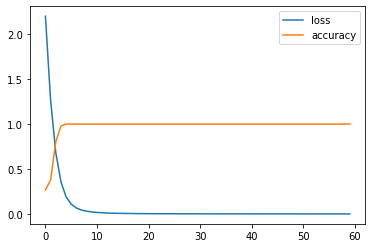

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


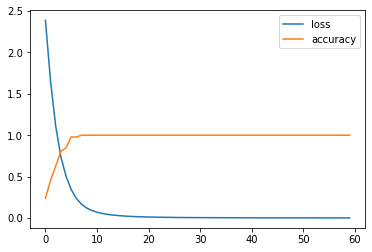

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


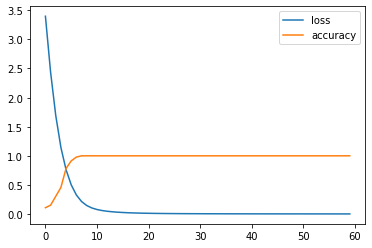

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


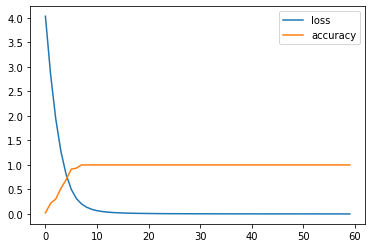

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


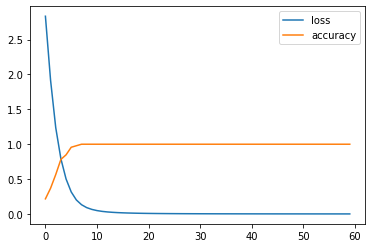

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


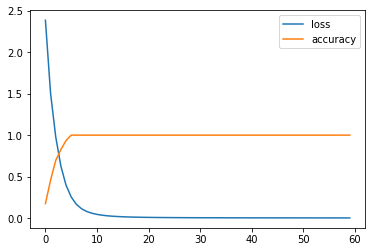

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


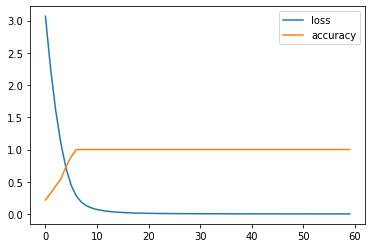

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


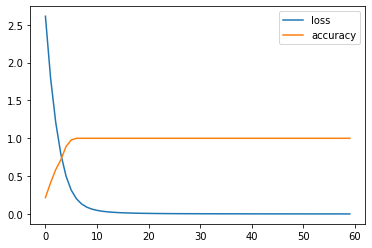

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


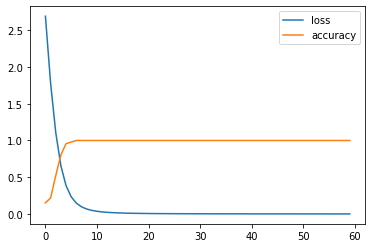

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


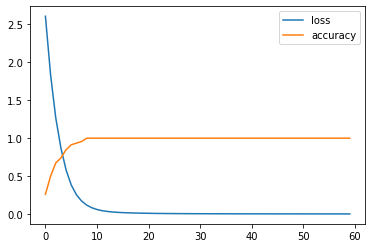

1.0

In [30]:
#Cross-validation and test 三核最佳结果
outer = StratifiedKFold(n_splits = 10,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='MK',dense_layers=[128], dropout = 0)
    opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    history = clf.fit(train_X, train_Y, batch_size=64, epochs=60, verbose=0)

    probs = clf.predict(test_X)
    y_pred = np.argmax(probs, axis=1)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc = Sum_acc + acc
    #plot train curve
    PlotCurve(history)
Sum_acc / 10

### 3. 小鼠血浆测试 健康：黑色素瘤：早期肿瘤：中期肿瘤：晚期肿瘤 = 9：6：9：6：12

In [62]:
dfx = LoadMSData(root_path = root_path, data_path = 'data1/mouse_blood/peaks_0.2.csv', t = False)
Y = np.zeros((42,5))                                             #将标签以独热编码存起来42
for i in range (0,9):                                           #健康 9例
    Y[i,0] = 1                                                     
for i in range (9,15):                                          #黑色素瘤 6例
    Y[i,1] = 1                                                    
for i in range (15,24):                                          #早期 9例
    Y[i,2] = 1 
for i in range (24,30):                                          #中期 6例
    Y[i,3] = 1                                                    
for i in range (30,42):                                          #晚期 12例
    Y[i,4] = 1 
y = Y.astype(int)
Y = np.zeros(42)                                                 #用于分层的标签
for i in range (0,9):                                           #健康 9例
    Y[i] = 0                                                     
for i in range (9,15):                                          #黑色素瘤 6例
    Y[i] = 1                                                    
for i in range (15,24):                                          #早期 9例
    Y[i] = 2 
for i in range (24,30):                                          #中期 6例
    Y[i] = 3                                                    
for i in range (30,42):                                          #晚期 12例
    Y[i] = 4 
Y = Y.astype(int)

In [63]:
mp = AggMap(dfx, metric = 'euclidean')                          #使用欧式距离
mp.fit(cluster_channels=5, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data1', file_type = 'aggmap', file_name = 'aggmap_mouse_blood_0.2.mp')

2023-12-21 19:43:37,459 - INFO - [bidd-aggmap] - Calculating distance ...
2023-12-21 19:43:37,481 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 127/127 [00:00<00:00, 210.91it/s]


2023-12-21 19:43:43,590 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2023-12-21 19:43:44,233 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2023-12-21 19:43:44,293 - INFO - [bidd-aggmap] - Finished


In [64]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 42/42 [00:18<00:00,  2.24it/s]


In [60]:
#原代码 复现
#Cross-validation and test
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = AggMapNet.MultiClassEstimator(epochs=200,gpuid=4,conv1_kernel_size=3)         #显存不足记得更改gpu
    clf.fit(train_X, train_Y)                                       #模型训练
    
    #AggMapNet Test Metrics
    acc = accuracy_score(test_y,clf.predict(test_X))
    rec = recall_score(test_y, clf.predict(test_X),average="micro")
    f1 = f1_score(test_y, clf.predict(test_X),average="micro")
    pr = precision_score(test_y, clf.predict(test_X),average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc = Sum_acc + acc

MultiClassEstimator(batch_norm=False, batch_size=128, conv1_kernel_size=3,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=200, gpuid='4', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0
MultiClassEstimator(batch_norm=False, batch_size=128, conv1_kernel_size=3,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=200, gpuid='4', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
Acc 

Acc =  0.8888888888888888
f1_score =  0.8888888888888888
average_precision =  0.8888888888888888
recall_score =  0.8888888888888888


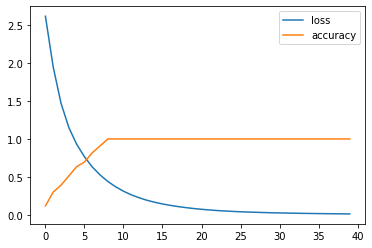

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


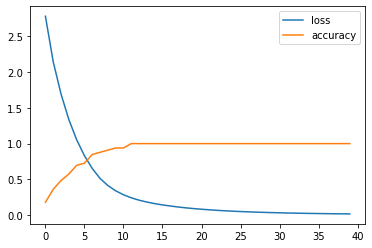

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


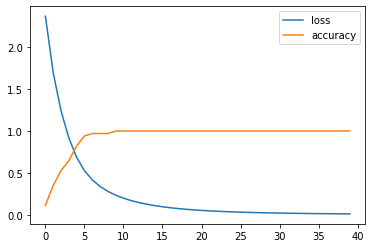

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


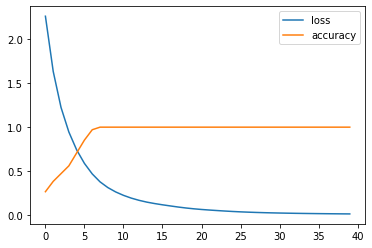

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


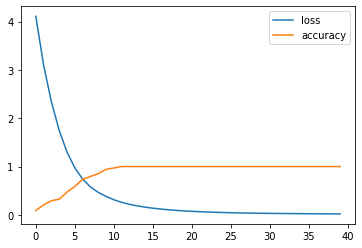

0.9777777777777779

In [50]:
#Cross-validation and test 三核最佳结果
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='MK',units=[12,24,48],dense_layers=[64,32], dropout = 0)
    opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    history = clf.fit(train_X, train_Y, batch_size=64, epochs=40, verbose=0)

    probs = clf.predict(test_X)
    y_pred = np.argmax(probs, axis=1)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc = Sum_acc + acc
    #plot train curve
    PlotCurve(history)
Sum_acc / 5

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


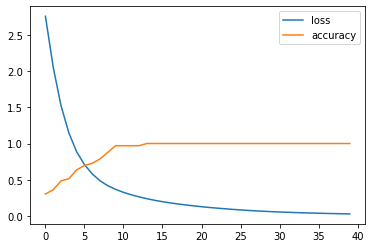

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


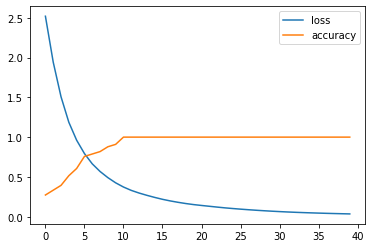

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


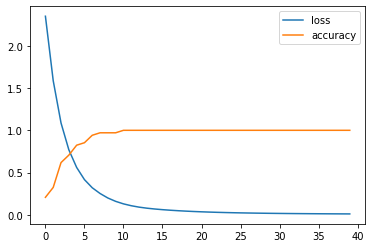

Acc =  0.875
f1_score =  0.875
average_precision =  0.875
recall_score =  0.875


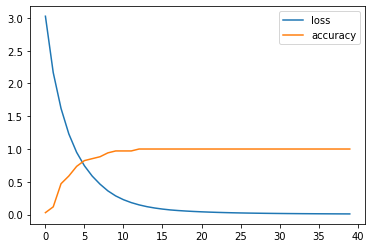

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


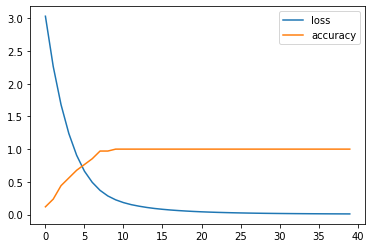

0.975

In [55]:
#Cross-validation and test 三核最佳结果
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='MK',units=[12,24,48],dense_layers=[128,32], dropout = 0)
    opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    history = clf.fit(train_X, train_Y, batch_size=128, epochs=40, verbose=0)

    probs = clf.predict(test_X)
    y_pred = np.argmax(probs, axis=1)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc = Sum_acc + acc
    #plot train curve
    PlotCurve(history)
Sum_acc / 5

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


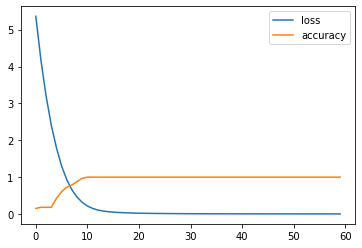

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


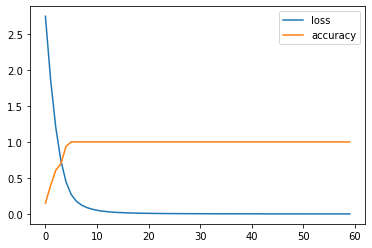

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


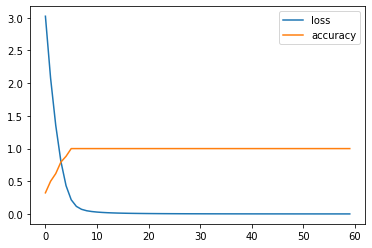

Acc =  0.875
f1_score =  0.875
average_precision =  0.875
recall_score =  0.875


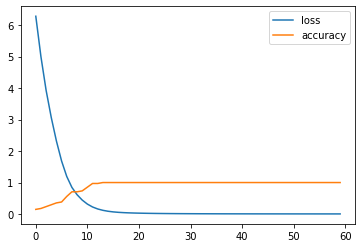

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


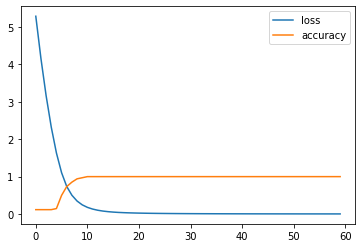

0.975

In [66]:
#Cross-validation and test 三核最佳结果
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='MK',units=[12,24,48],dense_layers=[128], dropout = 0)
    opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    history = clf.fit(train_X, train_Y, batch_size=128, epochs=60, verbose=0)

    probs = clf.predict(test_X)
    y_pred = np.argmax(probs, axis=1)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc = Sum_acc + acc
    #plot train curve
    PlotCurve(history)
Sum_acc / 5

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


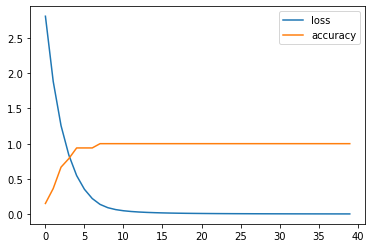

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


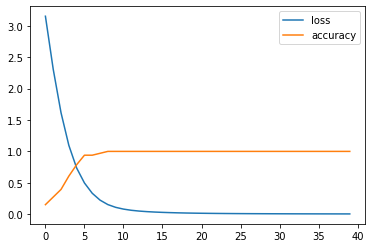

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


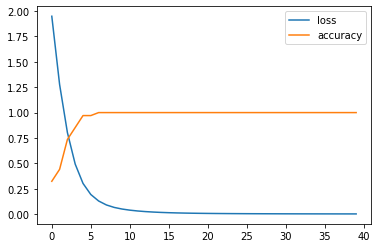

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


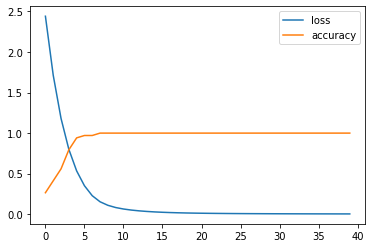

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


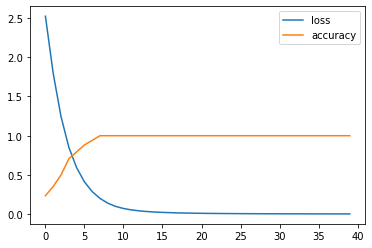

1.0

In [72]:
#Cross-validation and test 三核最佳结果
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='MK',units=[12,12,24],dense_layers=[64], dropout = 0)
    opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    history = clf.fit(train_X, train_Y, batch_size=128, epochs=40, verbose=0)

    probs = clf.predict(test_X)
    y_pred = np.argmax(probs, axis=1)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc = Sum_acc + acc
    #plot train curve
    PlotCurve(history)
Sum_acc / 5

In [73]:
clf.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 11, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 12, 11, 12)   2952        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 11, 12)   1512        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 12, 11, 24)   1104        input_1[0][0]                    
______________________________________________________________________________________________

In [74]:
clf.save('/mnt/lzyt/SmallSamples/data1/model/model_mouse_blood_0.2_MK.h5')